In [1]:
# TODO Currently accesses .pos files from local directory. Must change to download from Zenodo when available
# TODO Check avg slip dist > e.g. 0.2 m filtering out 2 station poor picks
# Zachary Katz
# zachary_katz@mines.edu
# August 2024

# Make and save the catalog of Whillans Stick Slip Events from .pos files

# Imports
import os

import src.Catalog.CatalogWrapper as CatWrap
import src.Catalog.Catalog as Catalog
import logging

# %load_ext line_profiler

################################################################################
########################## User Defined Variables ##############################
# fmt: off
dir = "/mnt/d/csrs_2024/all" 
stas = ["la01", "la02", "la03", "la04", "la05", "la06", "la07", "la08", "la09",
        "la10", "la11", "la12", "la13", "la14", "la15", "la16", "la17", "la18",
        "ws04", "ws05",
        "gz01", "gz02", "gz03", "gz04", "gz05", "gz06", "gz07", "gz08", "gz09",
        "gz10", "gz11", "gz12", "gz13", "gz14", "gz15", "gz16", "gz17", "gz18",
        "gz19", "gz20",
        "mg01", "mg02", "mg03", "mg04", "mg05", "mg06", "mg07",
        "slw1"
        ]
year_arr = [["2007","2008","2009"]]
year_arr = [["2016","2017","2018","2019"]]
max_gap_len = 120
# Currently implemented: ERROR, WARNING, INFO, DEBUG
# Each level also includes all levels above it.
loglevel = "INFO" 
# fmt: on
########################## User Defined Variables ##############################
################################################################################

In [19]:
def set_log_level(loglevel: str) -> None:
    """Set logging level for the run

    Parameters
    ----------
    loglevel : str
        Logging level
    """
    FORMAT = "%(asctime)s %(name)s %(levelname)s: %(message)s"
    DATEFMT = "%Y-%m-%d %H:%M:%S"
    if loglevel == "ERROR":
        logging.basicConfig(
            format=FORMAT, datefmt=DATEFMT, level=logging.ERROR, force=True
        )
    elif loglevel == "WARNING":
        logging.basicConfig(
            format=FORMAT, datefmt=DATEFMT, level=logging.WARNING, force=True
        )
    elif loglevel == "INFO":
        logging.basicConfig(
            format=FORMAT, datefmt=DATEFMT, level=logging.INFO, force=True
        )
    elif loglevel == "DEBUG":
        logging.basicConfig(
            format=FORMAT, datefmt=DATEFMT, level=logging.DEBUG, force=True
        )

In [20]:
# Setup logger
set_log_level(loglevel)
logger = logging.getLogger(__name__)

# Create Catalog
for years in year_arr:
    cats = []
    for sta in stas:
        interpolation_time, run = Catalog.set_interpolation_time(sta, years)
        if run:
            logger.info(f"Creating Dataframe for {sta}")
            cat = Catalog.Datastream(
                os.path.join(dir, sta), sta, years, interpolation_time
            )
            logger.info(f"Interpolating {sta}")
            if not cat.data.empty:
                cat.findgaps(max_gap_len)
                cats.append(cat)

    logger.info("Creating Catalog")

    catalog = CatWrap.full_catalog_run(
        cats,
        years,
        window=600,
        slide=20,
        active_stas=2,
        cull_time=30,
        cull_dist=0.1,
        plot=False,
    )

2024-08-26 14:38:28 __main__ INFO: Creating Dataframe for la01
2024-08-26 14:38:28 __main__ INFO: Interpolating la01
2024-08-26 14:38:28 __main__ INFO: Creating Dataframe for la02
2024-08-26 14:39:10 __main__ INFO: Interpolating la02
2024-08-26 14:39:11 src.Catalog.Catalog INFO: 2016-12-18 04:29:45 2016-12-18 04:30:30 0 days 00:00:45
2024-08-26 14:39:14 src.Catalog.Catalog INFO: 2017-01-27 09:59:45 2017-01-27 10:00:30 0 days 00:00:45
2024-08-26 14:39:16 src.Catalog.Catalog INFO: 2017-02-11 09:29:45 2017-02-11 09:30:30 0 days 00:00:45
2024-08-26 14:39:17 src.Catalog.Catalog INFO: 2017-02-21 19:44:45 2017-02-21 19:45:30 0 days 00:00:45
2024-08-26 14:39:26 src.Catalog.Catalog INFO: 2017-11-07 03:14:45 2017-11-07 03:15:30 0 days 00:00:45
2024-08-26 14:39:28 src.Catalog.Catalog INFO: 2017-11-29 04:32:30 2017-11-29 04:33:30 0 days 00:01:00
2024-08-26 14:39:30 src.Catalog.Catalog INFO: 2017-12-26 17:59:45 2017-12-26 18:00:30 0 days 00:00:45
2024-08-26 14:39:34 src.Catalog.Catalog INFO: 2018-0

573


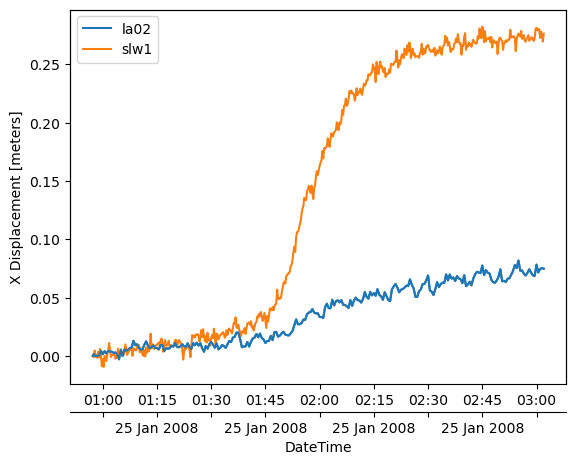

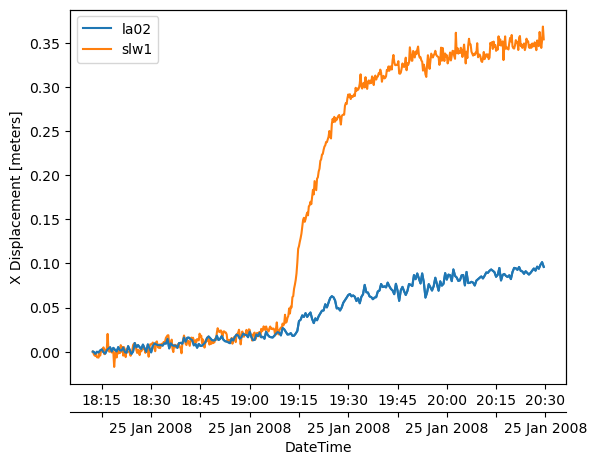

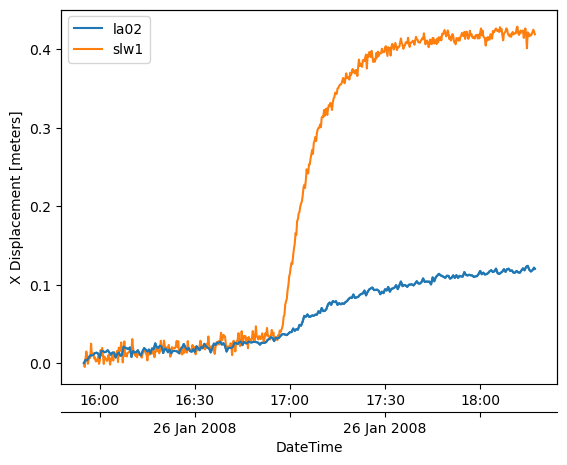

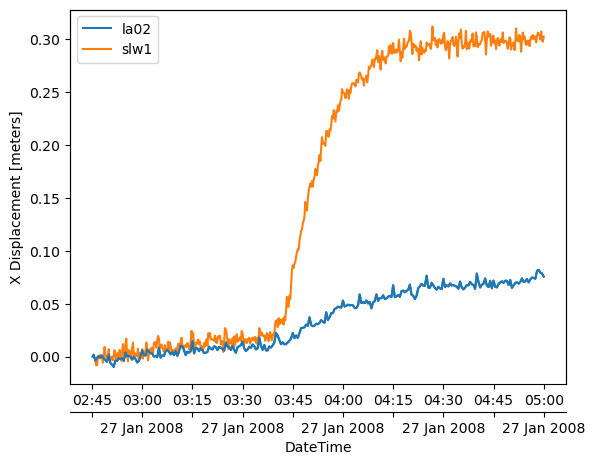

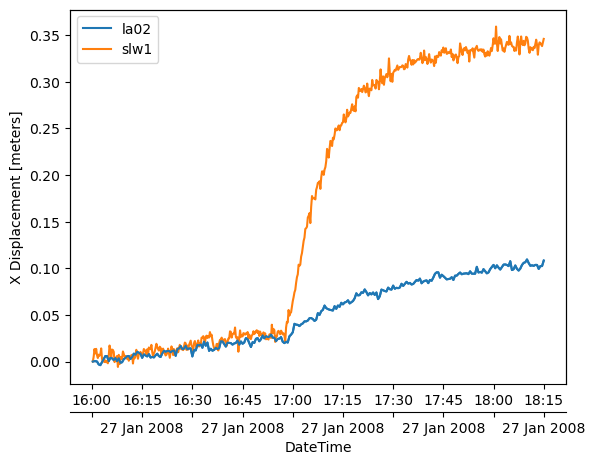

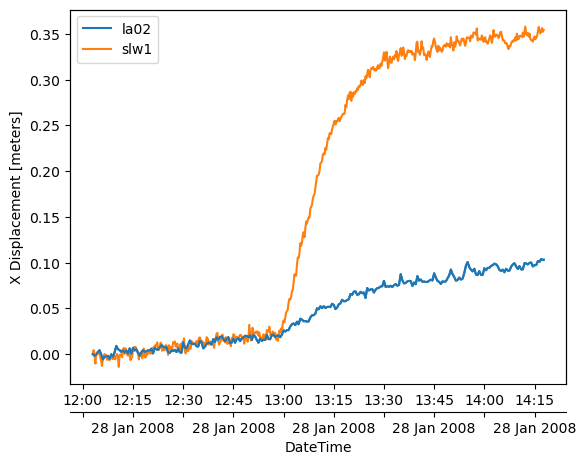

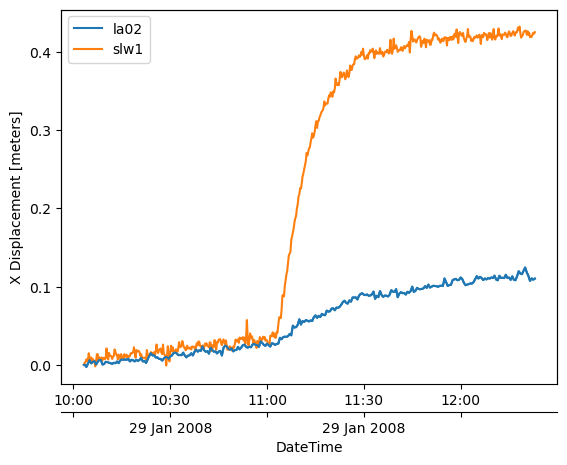

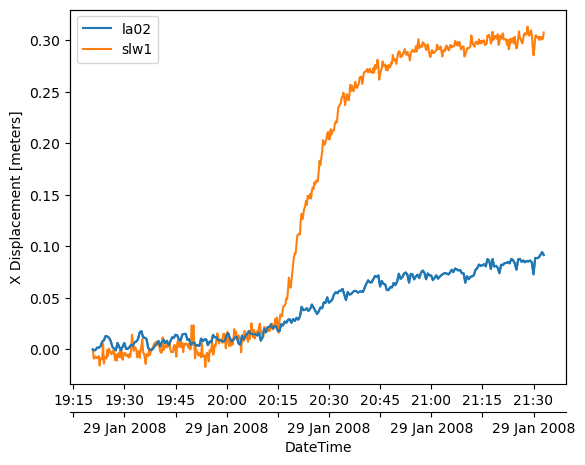

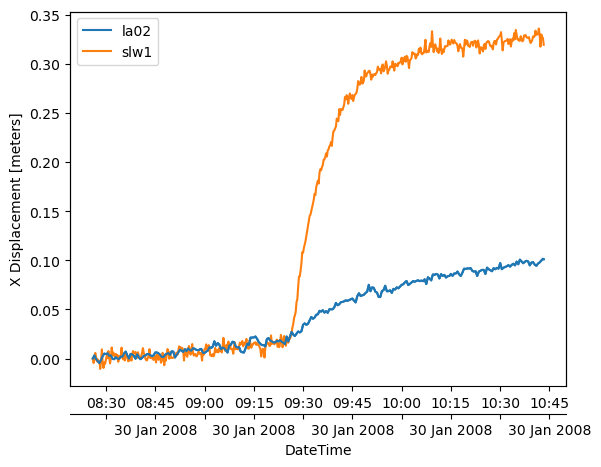

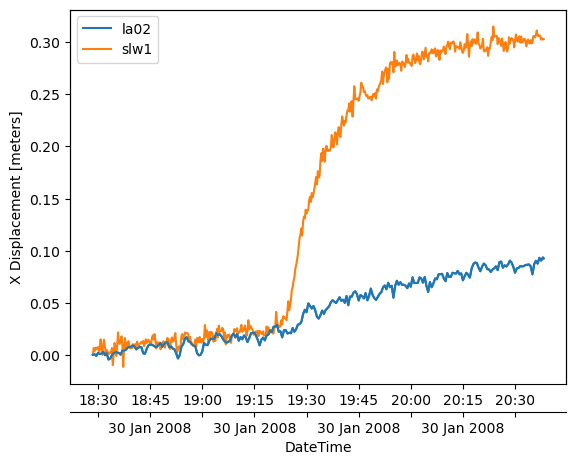

In [17]:
# Plot Example Events
print(len(catalog))
for event in catalog[:10]:
    Catalog.plot_event(event)